In [1]:
import numpy as np

from scipy import linalg

import Ipynb_importer

import new_topo as tp

import conductors_calculation as cc

class ChainNetwork:


    def __init__(self,

                 name="",

                 h=1,    # 基波、谐波次数。h = 1,基波；h >1 ,谐波

                 delta_length=1,    # 基本分段长度（km）

                 m=6,    # 归并后的导线数

                 topology=tp.Topology(name="AT_System"),   # 供电网络拓扑结构数据

                 ):

        self.name = name

        self.topology = topology

        self.h = h

        self.m = m

        self.section_length = self.topology.section_length    # 供电臂总长度

        self.delta_length = delta_length    # 基本分段长度

        self.n = int(np.round(self.section_length / self.delta_length) + 1)  # 分割面数，即网络节点数
        
        #if np.round(self.section_length / self.delta_length)<(self.section_length / self.delta_length):
            
            #self.n = int(np.round(self.section_length / self.delta_length) + 1)
            
        #else:
            
            #self.n = int(np.round(self.section_length / self.delta_length))

        self.distances = self.__set_distances()                # 分割点位置距离

        self.segment_lengths = self.__set_segment_lengths()    # 各分割段长度



        self.z = np.zeros((self.n-1, self.m, self.m), np.complex128)    # 网络纵向阻抗矩阵

        self.y = np.zeros((self.n, self.m, self.m), np.complex128)      # 网络横向导纳矩阵

        self.Un = np.zeros((self.n, self.m, 1), np.complex128)     # 节点电压向量

        self.In = np.zeros((self.n-1, self.m, 1), np.complex128)   # 纵向导线电流向量

        #self.Gn = np.zeros((self.m, 1), np.complex128)     # 节点注入电流向量
          
        self.Gn = np.zeros((self.m*self.n, 1), np.complex128)

        #print(self.z)
        
        #print(self.z.shape)
        
        #print(self.n)
        
        #print(self.Gn.shape)

    def reset(self, topology, h, m, delta_length):

        self.topology = topology

        self.h = h

        self.m = m

        self.delta_length = delta_length

        self.section_length = self.topology.section_length

        self.name = self.topology.name

        self.n = int(np.round(self.section_length / self.delta_length) + 1)  # 分割面数，即网络节点

        self.distances = self.__set_distances()  # 分割点位置距离

        self.segment_lengths = self.__set_segment_lengths()  # 各分割段长度


    def __set_distances(self):
        
        print(self.n)

        distances = np.arange(0, self.n, 1) * self.delta_length
        
        print(self.section_length)
        
        distances = distances.tolist()

        distances[-1] = self.section_length
        
        distances = np.array(distances)
        
        print(distances)
        
        print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')

        return distances



    def __set_segment_lengths(self):

        segment_lengths = np.zeros(self.n-1, np.float64)

        segment_lengths[:self.n-1] = self.distances[1:self.n] - self.distances[0:self.n-1]    # 分割段长度 （km）

        # print("segment_num = ", self.segment_lengths.shape)
        
        print(segment_lengths)
        
        print("bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb")

        return segment_lengths



    def set_z_y(self):

        unit_z = self.__calc_unit_z()

        unit_yc = self.__calc_unit_yc()



        for i in range(self.n-1):

            self.z[i, :, :] = unit_z*self.segment_lengths[i]

        for i in range(1, self.n-1):

            self.y[i, :, :] = unit_yc * (self.segment_lengths[i-1]/2 + self.segment_lengths[i]/2)

            self.y[0, :, :] = unit_yc * (self.segment_lengths[0]/2)

            self.y[self.n-1, :, :] = unit_yc * (self.segment_lengths[self.n-2]/2)

        print('lllllllllllllllllllllllllllllllllllllllllllllllllllllll')

        print("y=", self.y[0, :, :])

        print(self.z.shape)





    def construct_M(self):

        n = self.n

        m = self.m

        Dk = np.zeros((n, m, m), np.complex128)

        Mk = np.zeros((n, m, m), np.complex128)

        M = np.zeros((m*n, m*n), np.complex128)

        for k in range(1, n):   # 生产Dk元素矩阵

            Dk[k, :, :] = -linalg.inv(self.z[k-1, :, :])



        for k in range(1, n-1):    # 生成Mk元素矩阵

            Mk[k, :, :] = self.y[k, :, :] + linalg.inv(self.z[k, :, :]) + linalg.inv(self.z[k -1, :, :])



        Mk[0, :, :] = self.y[0, :, :] + linalg.inv(self.z[0, :, :])

        Mk[n-1, :, :] = self.y[n-1, :, :] + linalg.inv(self.z[n-2, :, :])



        for i in range(n):

            if i == 0:
                
                #self.M[0:m, 0:m] = Mk[:, :, 0]

                M[0:m, 0:m] = Mk[0, :, :]

            else:

                k = i*m  # 分块起点号

                M[k:k+m, k-m:k] = Dk[i, :, :]

                M[k - m: k, k:k + m] = Dk[i, :, :]

                M[k:k+m, k:k+m] = Mk[i, :, :]
            
        print(M.shape)
        #print(M)

        return M



    def solution(self):

       # self.set_z_y()

       # self.add_y()

        # #self.add_G()

        M = self.construct_M()

        W = linalg.inv(M)##改动

        #G = self.source()

        U = np.dot(W, self.Gn)
        print('显示U')
        print(U)
        print('U显示结束')

        #Un = U.reshape(self.m, self.n)
        
        Un = np.zeros((self.m,self.n))
        
        for i in range(self.n):
            
            Un[:,i] = U[i*self.m:i*self.m+6,0]
        
        In = np.zeros((self.m,self.n-1), np.complex128)#

        for k in range(self.n-1):

            z = self.z[k, :, :]

            z = linalg.inv(z)

            u = Un[:, k]-Un[:, k+1]
            
            print(u)
            
            u = np.mat(u)
            
            print(u.shape)
            
            u = u.T
            
            print(u)
            
            Ini = np.dot(z,u)
            
            Ini = np.mat(Ini)
            
            Ini = Ini.T
            print('Ini的大小')
            print(Ini.shape)
            
            for j in  range(0,self.m,1):
            
                In[j:,k] = Ini[0,j]

            
            print('显示In的大小')
            print(In.shape)
            #print('显示Un')
            #print(Un)
            print('显示In')
            print(In[:,1])
            print('结束')
            
        
        return Un,In



    def add_y(self):

        cross_connections = self.topology.cross_connections[0]
        
        y0 = 10**8    # 连接导线的电导率

        if self.m == 6:

            for x in cross_connections.to_all:        # 全并联连接线

                k = int(np.round(x/self.delta_length))

                self.y[k, :, :] = self.y[k, :, :] + y6_to_all*y0



            for x in cross_connections.ra1_g:

                k = int(np.round(x/self.delta_length))

                if k < self.n:

                    rg = cross_connections.ra1_g.get(x)
                    
                    print('rg')
                    print(rg)

                    self.y[k, :, :] = self.y[k, :, :] + y6_ra1_g * (1/rg)



            for x in cross_connections.ra3_g:

                k = int(np.round(x / self.delta_length))

                if k < self.n:

                    rg = cross_connections.ra3_g.get(x)

                    self.y[k, :, :] = self.y[k, :, :] + y6_ra3_g * (1 / rg)



            for x in cross_connections.e1_g:

                k = int(np.round(x / self.delta_length))

                if k < self.n:

                    rg = cross_connections.e1_g.get(x)

                    self.y[k, :, :] = self.y[k, :, :] + y6_e1_g * (1 / rg)

    

            for x in cross_connections.e2_g:

                k = int(np.round(x / self.delta_length))

                if k < self.n:

                    rg = cross_connections.e2_g.get(x)

                    self.y[k, :, :] = self.y[k, :, :] + y6_e2_g * (1 / rg)
            
            
    def add_y_source_two(self):
            
        traction = self.topology.traction_transformer
        print(traction[0].zs)
        
        self.y[0,0,0] = 1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,0,0]  #zs为牵引变压器内阻抗    traction[0].zs
        
        ##其中zs=Z0+Z1,Z0为电力系统电源侧归算到次边的阻抗值，Z1为归算到次边的电源变压器原、次边漏抗值。
            
        self.y[0,1,0] = - 1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,1,0]
            
        self.y[0,0,1] = - 1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,0,1]
            
        self.y[0,1,1] =  1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,1,1]

        
        self.y[0,0,0] = self.y[0,0,0] + 10**8
        
        self.y[0,3,0] = self.y[0,3,0] - 10**8
        
        self.y[0,0,3] = self.y[0,0,3] - 10**8
        
        self.y[0,3,3] = self.y[0,3,3] + 10**8
        
        
        self.y[0,1,1] = self.y[0,0,0] + 10**8
        
        self.y[0,1,4] = self.y[0,3,0] - 10**8
        
        self.y[0,4,1] = self.y[0,0,3] - 10**8
        
        self.y[0,4,4] = self.y[0,3,3] + 10**8
    

        return self.y
    
    def add_y_source_three(self):
            
        traction = self.topology.traction_transformer
        print(traction[0].zs)
        
        self.y[0,0,0] = 1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,0,0]  #zs为牵引变压器内阻抗    traction[0].zs
        
        ##其中zs=Z0+Z1,Z0为电力系统电源侧归算到次边的阻抗值，Z1为归算到次边的电源变压器原、次边漏抗值。
            
        self.y[0,1,0] = - 1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,1,0]
            
        self.y[0,0,1] = - 1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,0,1]
            
        self.y[0,1,1] =  1/(traction[0].zs_real+ 1j*traction[0].zs_imag) + self.y[0,1,1]

        
        self.y[0,0,0] = self.y[0,0,0] + 10**8
        
        self.y[0,3,0] = self.y[0,3,0] - 10**8
        
        self.y[0,0,3] = self.y[0,0,3] - 10**8
        
        self.y[0,3,3] = self.y[0,3,3] + 10**8
        
        
        self.y[0,1,1] = self.y[0,0,0] + 10**8
        
        self.y[0,1,4] = self.y[0,3,0] - 10**8
        
        self.y[0,4,1] = self.y[0,0,3] - 10**8
        
        self.y[0,4,4] = self.y[0,3,3] + 10**8
    

        return self.y
    
    def __get_line_parameter(self):    # 获取导线参数

        c_xy = []

        c_resistance = []

        c_mu_r = []

        c_radius = []

        c_equivalent_radius = []

        c_rho = []

        earth_rou = self.topology.earth_rou

        for line in self.topology.lines:

            c_xy.append([line.coordinater_x, line.coordinater_y])

            c_resistance.append(line.resistance)

            c_mu_r.append(line.mu_r)

            c_radius.append(line.radius)

            c_equivalent_radius.append(line.equivalent_radius)

            c_rho.append(line.rho)

        return c_xy, earth_rou, c_resistance, c_mu_r, c_radius, c_equivalent_radius, c_rho



    def __get_line_parameter_test(self):    # 设定测试导线参数

        c_xy = cc.conductors_coordinator

        c_resistance = cc.Rd

        c_mu_r = cc.mu_r

        c_radius = cc.conductors_calc_radius

        c_equivalent_radius = cc.conductors_equivalent_radius

        c_rho = cc.rho

        earth_rou = self.topology.earth_rou

        return c_xy, earth_rou, c_resistance, c_mu_r, c_radius, c_equivalent_radius, c_rho



    def __calc_unit_z(self):

        """

        计算平行导线原始单位阻抗矩阵

        :return:     阻抗矩阵

        """

        c_xy, earth_rou, c_resistance, c_mu_r, c_radius, c_equivalent_radius, c_rho = self.__get_line_parameter_test()

        f = 50*self.h     # 频率

        z = cc.calc_Zf(f, c_xy, c_radius, c_resistance, c_rho, c_mu_r, earth_rou)

        if self.m == 6:

            z = cc.merge_z(z, 0, 1)

            z = cc.merge_z(z, 2, 3)

            z = cc.merge_z(z, 2, 3)

            z = cc.merge_z(z, 2, 3)

            z = cc.merge_z(z, 3, 4)

            z = cc.merge_z(z, 5, 6)

            z = cc.merge_z(z, 5, 6)

            z = cc.merge_z(z, 5, 6)

        unit_z = z
        
        print("**************************************************************************")
        
        print(abs(unit_z))
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

        return unit_z



    def __calc_unit_yc(self):

        """

        计算导线的单位电容导纳矩阵

        :return:

        """

        c_xy, earth_rou, c_resistance, c_mu_r, c_radius, c_equivalent_radius, c_rho = self.__get_line_parameter_test()

        p = cc.calc_potential_coefficient(c_xy, c_radius)

        if self.m == 6:

            p = cc.merge_potential_coefficient(p, 0, 1)    # 合并成6根导线

            p = cc.merge_potential_coefficient(p, 2, 3)

            p = cc.merge_potential_coefficient(p, 2, 3)

            p = cc.merge_potential_coefficient(p, 2, 3)

            p = cc.merge_potential_coefficient(p, 3, 4)

            p = cc.merge_potential_coefficient(p, 5, 6)

            p = cc.merge_potential_coefficient(p, 5, 6)

            p = cc.merge_potential_coefficient(p, 5, 6)

        b = cc.calc_B(p)    # 计算电容

        f = 50*self.h
        
        print("[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]")

        unit_yc = -1j*2*np.pi*f*b   # 计算电容导纳
        
        print(unit_yc)
        
        print("******************************************************************")
        
        print(abs(unit_yc))
  
        return unit_yc

    def source(self):
        
        #print(G.shape)
        
        #print(type(GG))
        
        ##电源
        self.Gn[0][0] = 27500
        
        self.Gn[1][0] = -27500
        
        return self.Gn
    
    
    def locomotives(self):
        
        locomotives = self.topology.locomotive
        
        locomotives_location = []
        
        locomotives_load = []
        
        locomotives_num = len(locomotives)
        
        for i in range(len(locomotives)):
            
            locomotives_location.append(locomotives[i].location)
            
            locomotives_load.append(locomotives[i].load)
            
                    
        for i in range(locomotives_num):
            
            k = int(np.round(locomotives_location[i] / self.delta_length))
            
            if k < self.n:

                self.Gn[k*self.m][0] = -1*locomotives_load[i]
                
                self.Gn[k*self.m+2][0] = locomotives_load[i]  #locomotives_load[i]
                
                #In[:, k] = In[:, k] + Ini
                
            #G = G.T
            
            #G = np.mat(G)

        return self.Gn
            
           
    def add_y_AT(self):
        
        ATs = self.topology.auto_transformers
        
        ATs_location = []
        
        ATs_num = len(ATs)
        
        #print(AT_matrix_6)
        print('AT')
        print(ATs[0].zs)
        print('AT')
        
        
        
        for i in range(len(ATs)):
            
            ATs_location.append(ATs[i].location)
            
        print(ATs_location)
            
        for i in range(ATs_num):
            
            k = int(np.round(ATs_location[i] / self.delta_length))
            
            if k < self.n:

                self.y[k, :, :] = self.y[k, :, :] + AT_matrix_6*(1/(ATs[i].zs_real+1j*ATs[i].zs_imag))   #yg为折算至中点的漏导纳   ATs[i].zs  
                
        return self.y
            
                
        #AT_matrix_6
        


# 定义基本导纳关联矩阵 (m=6)



AT_matrix_6 = cc.set_connction_matrix_AT(6, 0,2,1)  # AT导纳关联矩阵

y6_to_all = cc.set_connection_matrix(6, 0, 3) + cc.set_connection_matrix(6, 1, 4) + cc.set_connection_matrix(6, 2, 5)  # 上下行全并联导纳连接矩阵

y6_e1_g = cc.set_connction_matrix_g(6, 2)  # 综合地线e1连接大地g ，导纳关联矩阵

y6_e2_g = cc.set_connction_matrix_g(6, 5)  # 综合地线e2连接大地g ，导纳关联矩

y6_ra1_g = cc.set_connction_matrix_g(6, 2)  # 钢轨ra1连接大地g, 导纳关联矩阵

y6_ra3_g = cc.set_connction_matrix_g(6, 5)  # 钢轨ra3连接大地g, 导纳关联矩阵





if __name__ == '__main__':



    chen = ChainNetwork(h=1, m=6, delta_length=0.5)

    chen.set_z_y()
    
    chen.add_y_AT()
    
    YY = chen.add_y_source_two()
    
    print(YY.shape)
    
    
    chen.add_y()
    
    R = chen.source()
    
    print(R)
    
    print(R.shape)

    #print(chen.construct_M().shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    chen.locomotives()
    
    #print(Q)

    # print(chen.AT_matrix_6)

    # print(chen.y6_to_all)

    # print(chen.y6_e1_g)
    
    #print(Q)
    
    #print(Q.shape)
    #print(Q)
    
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    
    Q = chen.construct_M()
    print(Q)
    print(Q.shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    
    UU,II = chen.solution()
    print(UU,II)
    
    print('**********aaaaaaaa***************aaaaaaaaaaaa*************aaaaaaaaaaaaa*****************')
    
    print(UU.shape)
    
    print(II.shape)
    print('电流矩阵')
    print(II)
    print(chen.delta_length)

importing Jupyter notebook from new_topo.ipynb
牵引变压器的数量=1
AT变压器的数量=3
上下行并联线的数量=3
pw1与ra1连接线的数量=11
e1与ra1连接线的数量=62
e1与g连接线的数量=62
pw2与ra3连接线的数量=11
e2与g连接线的数量=62
ra1与g连接线的数量=62
ra3与g连接线的数量=62
机车的数量=1
cw1 0.0
mw1 0.0
pf1 -4400.0
ra1 -755.0
ra2 0
pw1 -3600.0
e1 -4400.0
cw2 5000.0
mw2 5000.0
pf2 9400.0
ra3 4245.0
ra4 5755.0
pw2 8600.0
e2 9400.0
一号 vx 0.0 0.1 0.45 <class 'complex'>
二号 vx 15.802 0.1 0.45 <class 'complex'>
三号 vx 30.6 0.1 0.45 <class 'complex'>
0.0
===eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee==================
2.0 0.0
[0.0, 15.802, 30.6]
[1.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0, 27.0, 30.0]
{0.0: 50.0, 0.5: 50.0, 2.0: 50.0, 3.0: 50.0, 4.0: 50.0, 5.0: 50.0, 6.0: 50.0, 1.5: 50.0, 8.0: 50.0, 9.0: 50.0, 10.0: 50.0, 11.0: 50.0, 12.0: 50.0, 2.5: 50.0, 14.0: 50.0, 15.0: 50.0, 16.0: 50.0, 17.0: 50.0, 18.0: 50.0, 3.5: 50.0, 20.0: 50.0, 21.5: 50.0, 22.0: 50.0, 23.0: 50.0, 24.0: 50.0, 4.5: 50.0, 22.5: 50.0, 27.0: 50.0, 28.0: 50.0, 26.0: 50.0, 30.0: 50.0, 5.5: 50.0, 27.5: 5

H:\Anaconda3\lib\site-packages\ipykernel\__main__.py:245: ComplexWarning: Casting complex values to real discards the imaginary part


## 绘图

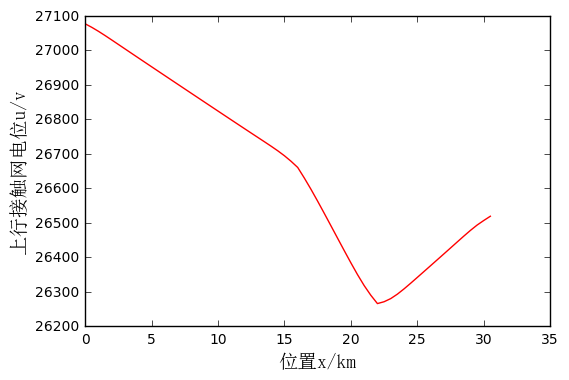

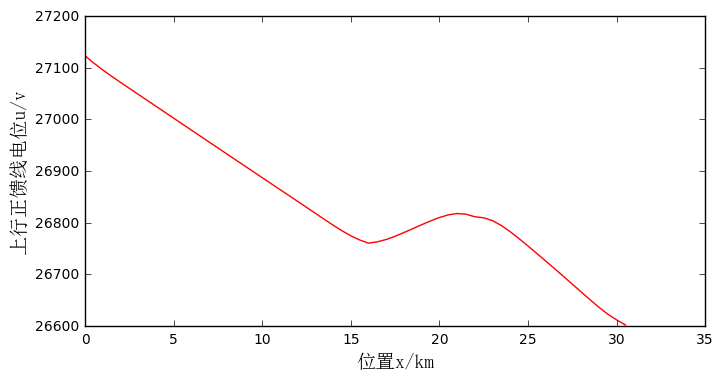

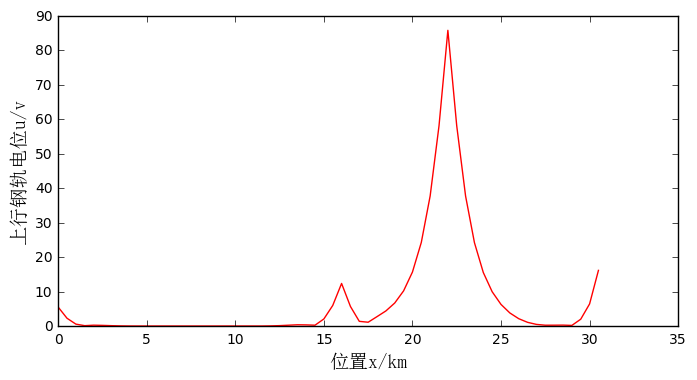

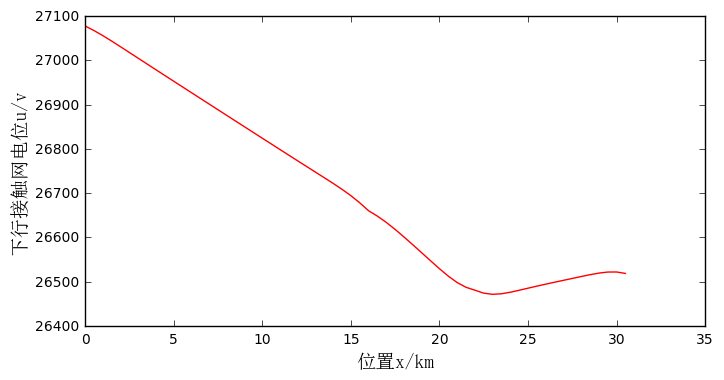

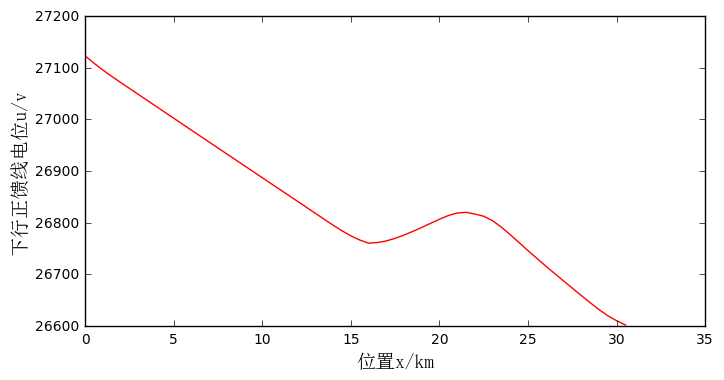

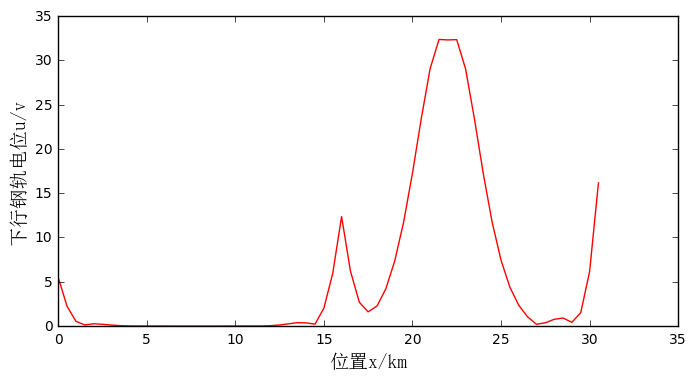

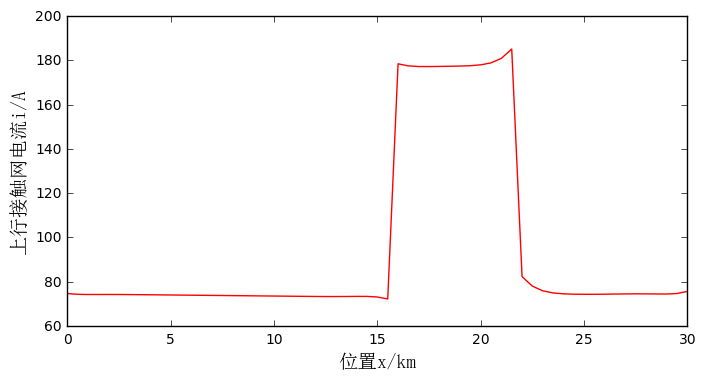

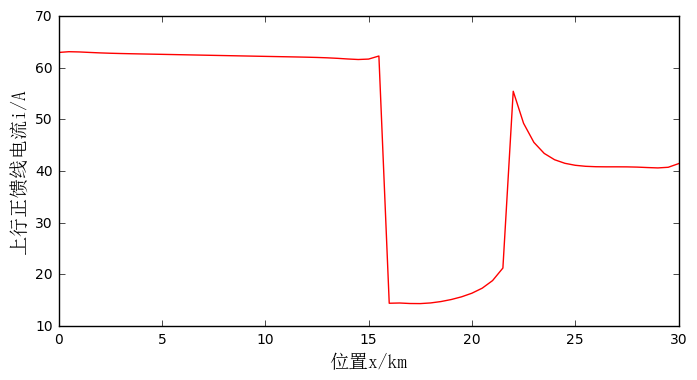

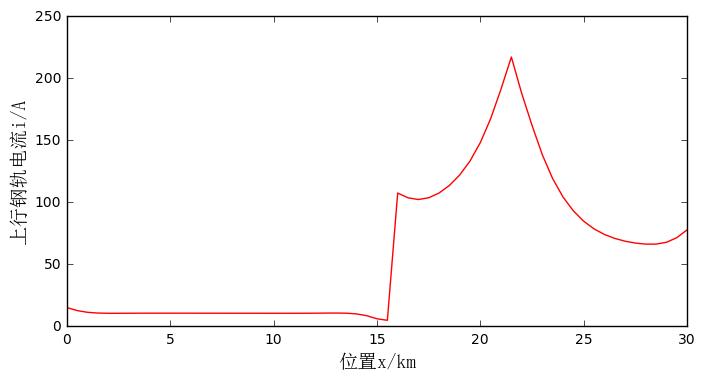

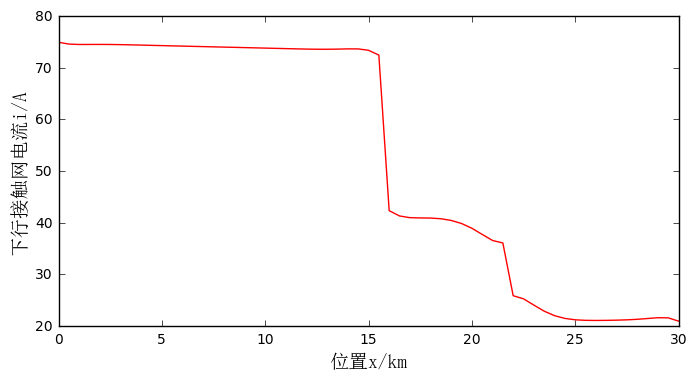

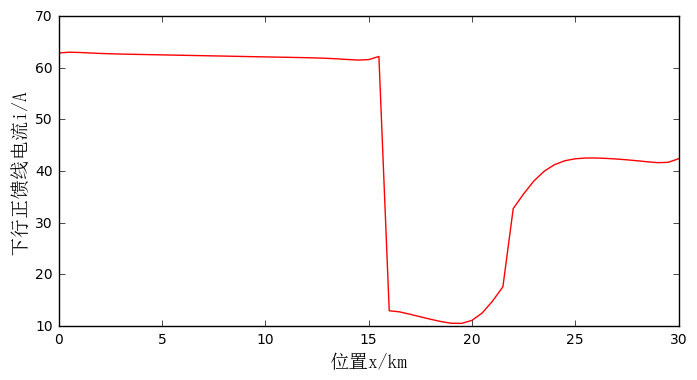

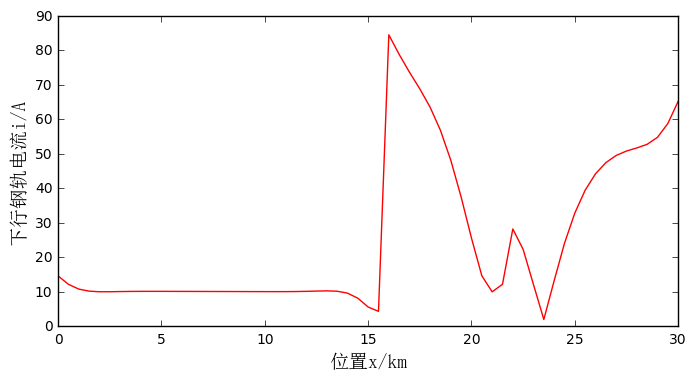

In [2]:
#接触线电压
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
#上行接触线电压
U_list_up_CW1 = []
for i in range(0,UU.shape[1],1):
    U_list_up_CW1.append(abs(UU[0,i]))
    #上行正馈线电压
U_list_up_PF1 = []
for i in range(0,UU.shape[1],1):
    U_list_up_PF1.append(abs(UU[1,i]))    
#上行钢轨电压
U_list_up_RA1 = []
for i in range(0,UU.shape[1],1):
    U_list_up_RA1.append(abs(UU[2,i]))

#下行接触线电压
U_list_down_CW2 = []
for i in range(0,UU.shape[1],1):
    U_list_down_CW2.append(abs(UU[3,i]))
#下行正馈线电压
U_list_down_PF2 = []
for i in range(0,UU.shape[1],1):
    U_list_down_PF2.append(abs(UU[4,i]))    
#下行钢轨电压
U_list_down_RA3 = []
for i in range(0,UU.shape[1],1):
    U_list_down_RA3.append(abs(UU[5,i]))


#上行接触线电流
I_list_up_CW1 = []
for i in range(0,II.shape[1],1):
    I_list_up_CW1.append(abs(II[0,i]))
#上行正馈线电流
I_list_up_PF1 = []
for i in range(0,II.shape[1],1):
    I_list_up_PF1.append(abs(II[1,i]))
#上行钢轨电流
I_list_up_RA1 = []
for i in range(0,II.shape[1],1):
    I_list_up_RA1.append(abs(II[2,i]))

#下行接触线电流
I_list_down_CW2 = []
for i in range(0,II.shape[1],1):
    I_list_down_CW2.append(abs(II[3,i]))
#下行正馈线电流
I_list_down_PF2 = []
for i in range(0,II.shape[1],1):
    I_list_down_PF2.append(abs(II[4,i]))
#下行钢轨电流
I_list_down_RA3 = []
for i in range(0,II.shape[1],1):
    I_list_down_RA3.append(abs(II[5,i]))

railway = []
for i in range(0,UU.shape[1],1):
    railway.append(i*chen.delta_length)
railway1 = []
for i in range(0,II.shape[1],1):
    railway1.append(i*chen.delta_length)


#上行电压
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('上行接触网电位u/v',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway,U_list_up_CW1,color='red')
#plt.title(u'第'+str(n)+'次谐波下接触线电流特性曲线', fontproperties=font_set)
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('上行正馈线电位u/v',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway,U_list_up_PF1,color='red')
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('上行钢轨电位u/v',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway,U_list_up_RA1,color='red')
plt.show()
#下行电压
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('下行接触网电位u/v',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway,U_list_down_CW2,color='red')
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('下行正馈线电位u/v',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway,U_list_down_PF2,color='red')
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('下行钢轨电位u/v',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway,U_list_down_RA3,color='red')
plt.show()


#上行电流
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('上行接触网电流i/A',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway1,I_list_up_CW1,color='red')
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('上行正馈线电流i/A',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway1,I_list_up_PF1,color='red')
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('上行钢轨电流i/A',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway1,I_list_up_RA1,color='red')
plt.show()

#下行电流
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('下行接触网电流i/A',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway1,I_list_down_CW2,color='red')
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('下行正馈线电流i/A',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway1,I_list_down_PF2,color='red')
plt.show()
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) 
plt.xlabel('位置x/km',fontproperties=font_set)
plt.ylabel('下行钢轨电流i/A',fontproperties=font_set)
plt.rcParams['figure.figsize']=(8.0,4.0)
plt.plot(railway1,I_list_down_RA3,color='red')
plt.show()

